In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer, average_precision_score, roc_auc_score, precision_score,
    recall_score, f1_score, roc_curve, precision_recall_curve, auc, confusion_matrix
)
import numpy as np

In [18]:
# Load and preprocess data (your existing code)
df = pd.read_csv('/Users/ormeiri/Desktop/predictive_models_git/data/chapter 4/data/multiple_imputation.csv')

In [19]:
target_column = "hospital_death"
X_original = df.drop(columns=[target_column])
y = df[target_column]

In [20]:
categorical_cols = X_original.select_dtypes(include=['object', 'category']).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_original, y, test_size=0.2,
                                                    random_state=42, stratify=y)

In [21]:
def preprocess_data(X, categorical_cols, is_training=True, scaler=None, dummy_cols=None):
    """
    Preprocess data with dummy variables and scaling for LogReg and KNN
    """
    # Create dummy variables
    X_dummy = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    if is_training:
        # Fit scaler on training data
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_dummy),
                               columns=X_dummy.columns, index=X_dummy.index)
        return X_scaled, scaler, X_dummy.columns.tolist()
    else:
        # Transform test data with fitted scaler
        # Ensure test data has same columns as training data
        X_dummy = X_dummy.reindex(columns=dummy_cols, fill_value=0)
        X_scaled = pd.DataFrame(scaler.transform(X_dummy),
                               columns=X_dummy.columns, index=X_dummy.index)
        return X_scaled, scaler, dummy_cols

In [22]:
# Preprocess data for LogReg and KNN (dummy variables + scaling)
X_train_scaled, scaler, dummy_cols = preprocess_data(X_train, categorical_cols, is_training=True)
X_test_scaled, _, _ = preprocess_data(X_test, categorical_cols, is_training=False,
                                    scaler=scaler, dummy_cols=dummy_cols)

In [23]:
# Prepare data for XGBoost (dummy variables without scaling)
X_train_xgb = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_xgb = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)
# Ensure test set has same columns as training set for XGBoost
X_test_xgb = X_test_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

In [24]:
models = {
    'XGBoost': XGBClassifier(
        colsample_bytree=0.8,
        gamma=0.1,
        learning_rate=0.1,
        max_depth=7,
        min_child_weight=3,
        subsample=0.8,
        random_state=42
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=3,
        weights='distance',
        algorithm='auto'
    ),
    'Logistic Regression': LogisticRegression(
        penalty='l2',
        C=0.1,
        max_iter=1000,
        random_state=42
    )
}

In [25]:
def bootstrap_metrics_with_curves(model, X_test, y_test, n_bootstrap=100):
    """
    Perform bootstrap sampling and calculate metrics with ROC and PR curves
    """
    np.random.seed(42)
    n_samples = len(X_test)

    bootstrap_results = {
        'auroc': [],
        'auprc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    roc_curves = []
    pr_curves = []

    for i in range(n_bootstrap):
        # Bootstrap sampling
        bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_bootstrap = X_test.iloc[bootstrap_indices]
        y_bootstrap = y_test.iloc[bootstrap_indices]

        # Get predictions
        y_pred_proba = model.predict_proba(X_bootstrap)[:, 1]
        y_pred = model.predict(X_bootstrap)

        # Calculate metrics
        auroc = roc_auc_score(y_bootstrap, y_pred_proba)
        auprc = average_precision_score(y_bootstrap, y_pred_proba)
        precision = precision_score(y_bootstrap, y_pred, zero_division=0)
        recall = recall_score(y_bootstrap, y_pred, zero_division=0)
        f1 = f1_score(y_bootstrap, y_pred, zero_division=0)

        bootstrap_results['auroc'].append(auroc)
        bootstrap_results['auprc'].append(auprc)
        bootstrap_results['precision'].append(precision)
        bootstrap_results['recall'].append(recall)
        bootstrap_results['f1'].append(f1)

        # Store curves
        fpr, tpr, _ = roc_curve(y_bootstrap, y_pred_proba)
        precision_curve, recall_curve, _ = precision_recall_curve(y_bootstrap, y_pred_proba)

        roc_curves.append((fpr, tpr))
        pr_curves.append((precision_curve, recall_curve))

    return bootstrap_results, roc_curves, pr_curves

In [26]:
def calculate_confidence_intervals(bootstrap_results, confidence_level=0.95):
    """
    Calculate mean and confidence intervals from bootstrap results.
    """
    alpha = 1 - confidence_level
    lower_percentile = (alpha/2) * 100
    upper_percentile = (1 - alpha/2) * 100

    results = {}
    for metric, values in bootstrap_results.items():
        mean_val = np.mean(values)
        ci_lower = np.percentile(values, lower_percentile)
        ci_upper = np.percentile(values, upper_percentile)
        results[metric] = {
            'mean': mean_val,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }

    return results

In [27]:
# Dictionary to store all results
all_bootstrap_results = {}
all_ci_results = {}

print("Training and evaluating models...")
print("=" * 60)

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'XGBoost':
        # XGBoost uses unscaled dummy data
        model.fit(X_train_xgb, y_train)
        X_test_model = X_test_xgb
    else:
        # KNN and LogReg use scaled data
        model.fit(X_train_scaled, y_train)
        X_test_model = X_test_scaled

    # Bootstrap evaluation
    print(f"  Bootstrapping {model_name}...")
    bootstrap_results, roc_curves, pr_curves = bootstrap_metrics_with_curves(
        model, X_test_model, y_test, n_bootstrap=100
    )

    # Calculate confidence intervals
    ci_results = calculate_confidence_intervals(bootstrap_results)

    # Store results
    all_bootstrap_results[model_name] = bootstrap_results
    all_ci_results[model_name] = ci_results

    # Print results
    print(f"\n{model_name} Results (95% Confidence Intervals):")
    print("-" * 50)
    for metric, stats in ci_results.items():
        print(f"  {metric:<12}: {stats['mean']:.4f} [{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]")

Training and evaluating models...

Training XGBoost...
  Bootstrapping XGBoost...

XGBoost Results (95% Confidence Intervals):
--------------------------------------------------
  auroc       : 0.9232 [0.9173, 0.9286]
  auprc       : 0.6199 [0.6000, 0.6404]
  precision   : 0.7417 [0.7126, 0.7699]
  recall      : 0.3745 [0.3487, 0.3988]
  f1          : 0.4976 [0.4705, 0.5206]

Training KNN...
  Bootstrapping KNN...

KNN Results (95% Confidence Intervals):
--------------------------------------------------
  auroc       : 0.6715 [0.6576, 0.6835]
  auprc       : 0.2783 [0.2577, 0.2989]
  precision   : 0.6473 [0.6022, 0.6917]
  recall      : 0.1652 [0.1474, 0.1849]
  f1          : 0.2631 [0.2383, 0.2903]

Training Logistic Regression...
  Bootstrapping Logistic Regression...

Logistic Regression Results (95% Confidence Intervals):
--------------------------------------------------
  auroc       : 0.8855 [0.8779, 0.8922]
  auprc       : 0.5306 [0.5105, 0.5531]
  precision   : 0.7014 [0.6721


Creating comparison boxplots...


/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_63067/1918967038.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(plot_data, labels=plot_labels, patch_artist=True)
/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_63067/1918967038.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(plot_data, labels=plot_labels, patch_artist=True)
/var/folders/68/dmpmrx5n0ts80f_y59l1n8y00000gn/T/ipykernel_63067/1918967038.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(plot_data, labels=plot_labels, patch_artist=True)
/var/folders/68/dmpmrx5n0

Boxplots saved as 'model_comparison_boxplots.png' and 'model_comparison_boxplots.pdf'


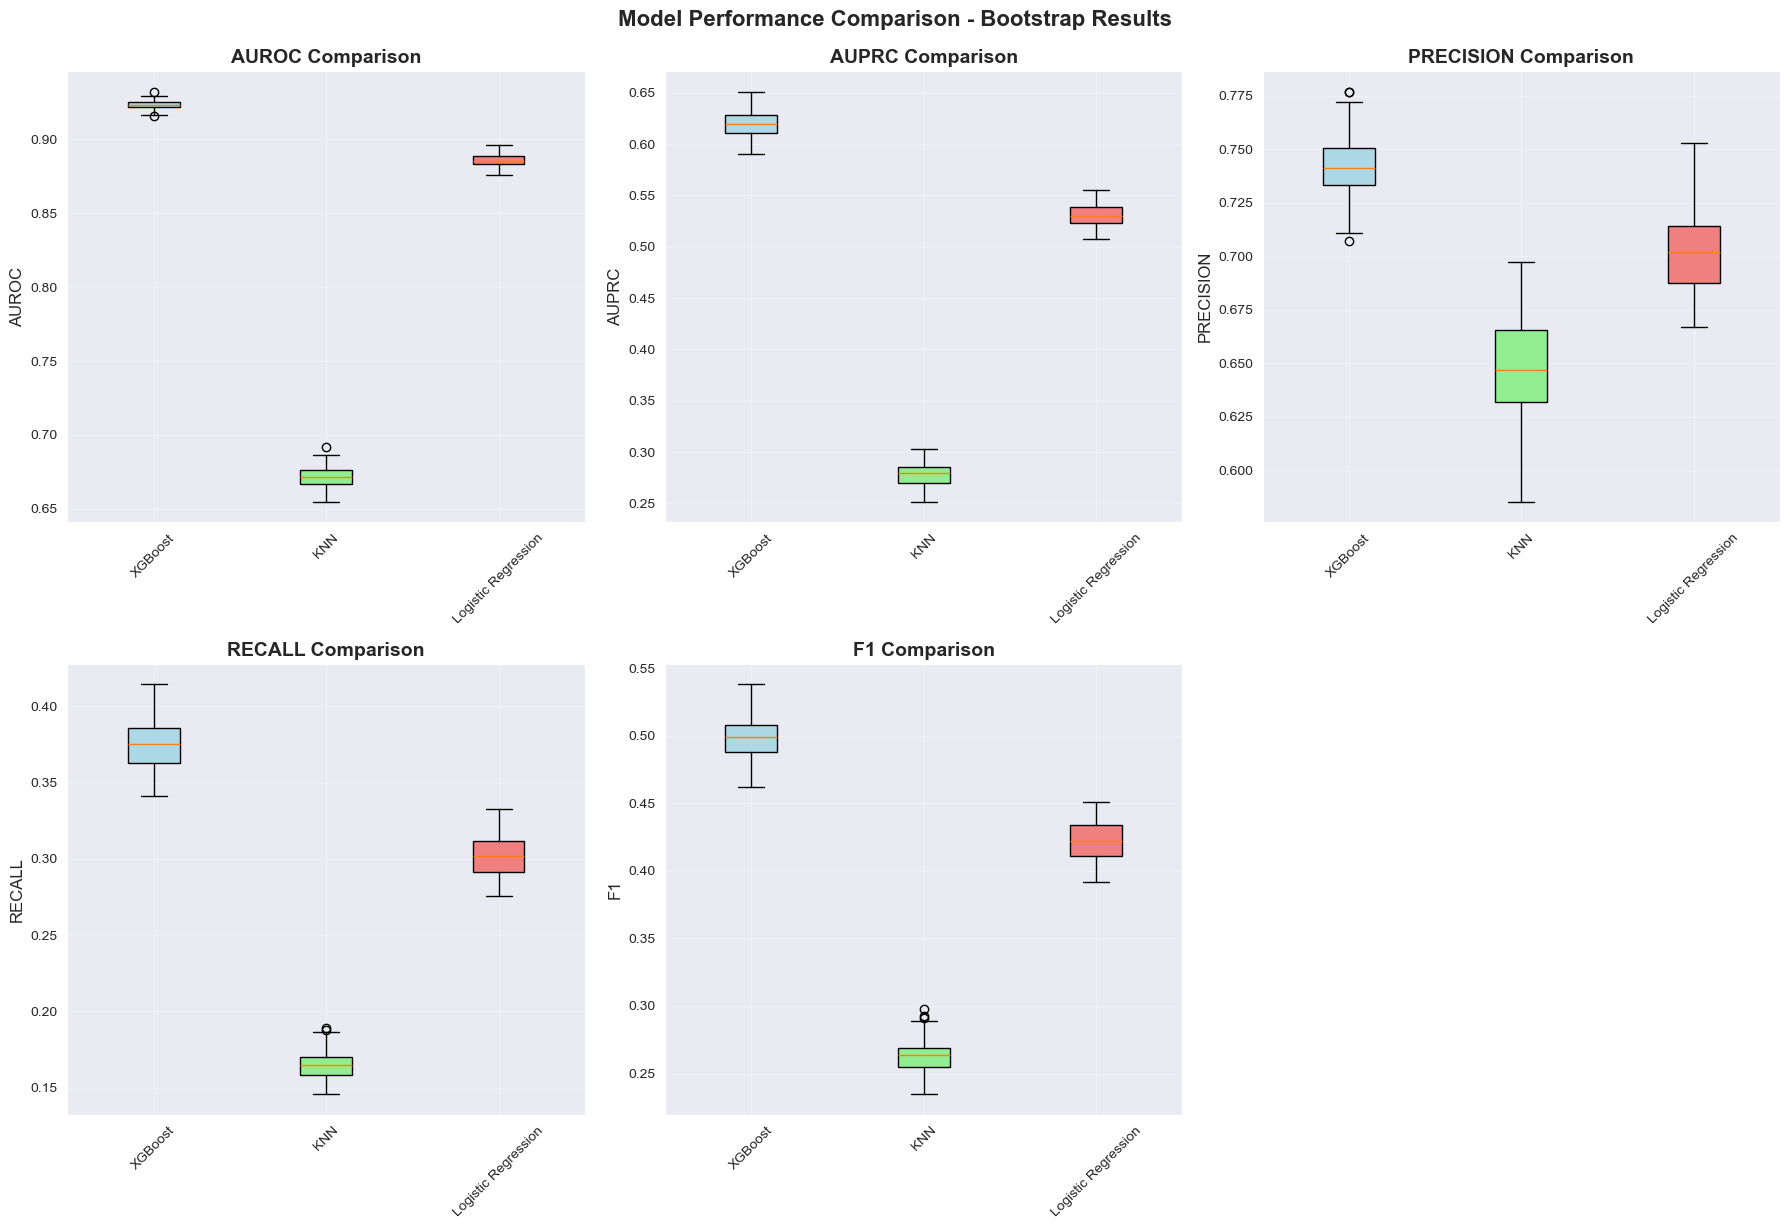

In [30]:
# Create boxplots comparing all models
print("\nCreating comparison boxplots...")

# Prepare data for boxplots
metrics_to_plot = ['auroc', 'auprc', 'precision', 'recall', 'f1']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    # Prepare data for this metric
    plot_data = []
    plot_labels = []

    for model_name in models.keys():
        plot_data.append(all_bootstrap_results[model_name][metric])
        plot_labels.append(model_name)

    # Create boxplot
    bp = axes[i].boxplot(plot_data, labels=plot_labels, patch_artist=True)

    # Customize colors
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    axes[i].set_title(f'{metric.upper()} Comparison', fontsize=14, fontweight='bold')
    axes[i].set_ylabel(f'{metric.upper()}', fontsize=12)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

# Remove the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.suptitle('Model Performance Comparison - Bootstrap Results', fontsize=16, fontweight='bold', y=1.02)

# Save the figure
plt.savefig('/Users/ormeiri/Desktop/predictive_models_git/images/model_comparison_boxplots.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig('model_comparison_boxplots.pdf', bbox_inches='tight', facecolor='white')
print("Boxplots saved as 'model_comparison_boxplots.png' and 'model_comparison_boxplots.pdf'")

plt.show()

In [29]:
# Statistical comparison (optional)
print("\n" + "="*80)
print("STATISTICAL COMPARISON")
print("="*80)

from scipy import stats

for metric in metrics_to_plot:
    print(f"\n{metric.upper()} - Pairwise t-tests:")
    model_names = list(models.keys())

    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            values1 = all_bootstrap_results[model1][metric]
            values2 = all_bootstrap_results[model2][metric]

            t_stat, p_value = stats.ttest_rel(values1, values2)
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

            print(f"  {model1} vs {model2}: p={p_value:.4f} {significance}")

print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")


STATISTICAL COMPARISON

AUROC - Pairwise t-tests:
  XGBoost vs KNN: p=0.0000 ***
  XGBoost vs Logistic Regression: p=0.0000 ***
  KNN vs Logistic Regression: p=0.0000 ***

AUPRC - Pairwise t-tests:
  XGBoost vs KNN: p=0.0000 ***
  XGBoost vs Logistic Regression: p=0.0000 ***
  KNN vs Logistic Regression: p=0.0000 ***

PRECISION - Pairwise t-tests:
  XGBoost vs KNN: p=0.0000 ***
  XGBoost vs Logistic Regression: p=0.0000 ***
  KNN vs Logistic Regression: p=0.0000 ***

RECALL - Pairwise t-tests:
  XGBoost vs KNN: p=0.0000 ***
  XGBoost vs Logistic Regression: p=0.0000 ***
  KNN vs Logistic Regression: p=0.0000 ***

F1 - Pairwise t-tests:
  XGBoost vs KNN: p=0.0000 ***
  XGBoost vs Logistic Regression: p=0.0000 ***
  KNN vs Logistic Regression: p=0.0000 ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05
